In [1]:
# Set up plot stuff the DFM way:

%run ../document/figures/plot_setup.py

In [2]:
# Get target list; this follows the selection in ../document/figures/targets.py 
import sys
sys.path.append('..')

from peerless.catalogs import KICatalog, KOICatalog, EBCatalog, BlacklistCatalog
import numpy as np
import pandas as pd

stlr = KICatalog().df
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.
m &= stlr.kepmag < 15.

# known EBs
ebs = set(np.array(EBCatalog().df["#KIC"]))

# KOI false positives
kois = KOICatalog().df
kois = kois[kois.koi_disposition == "FALSE POSITIVE"]
fps = set(np.array(kois.kepid))

# And then finally the blacklist.
bl = set(np.array(BlacklistCatalog().df.kicid))

# The full list of ignores.
ignore = fps | bl #ebs | fps | bl  #Don't ignore EBs for purposes of prediction
m &= ~stlr.kepid.isin(ignore)

targets = stlr[m]

In [3]:
targets[['kepid','mass','feh']].count()

kepid    39626
mass     38983
feh      39626
dtype: int64

In [4]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
from exosyspop import KeplerBinaryPopulation, TRILEGAL_BGBinaryPopulation

ebpop = KeplerBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5','df')
bgpop = TRILEGAL_BGBinaryPopulation(targets, bgstars, ecc_empirical=True)

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


EB: dmag regressor trained, R2=0.999481613511
EB: qR regressor trained, R2=0.999497979346


/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


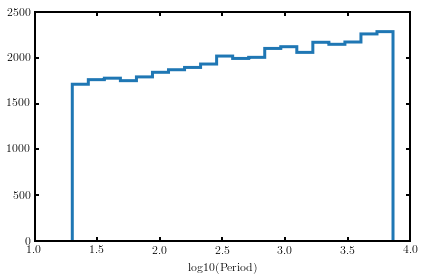

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(np.log10(ebpop.period), bins=20, histtype='step', lw=3);
plt.xlabel('log10(Period)');

In [19]:
ebpop.params

{'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.44,
 'gamma': 0.3,
 'mu_logp': 2.3979400086720375,
 'period_min': 5.0,
 'qmin': 0.1,
 'sig_logp': 2.3}

In [20]:
q = 'period > 10 and period < 1000 and ' +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'
ebs = ebpop.observe(new=True).query(q)
bgs = bgpop.observe(new=True, use_ic=True).query(q)
print('{} EBs'.format(len(ebs)))
print('{} BEBs'.format(len(bgs)))

66 EBs
40 BEBs


OK, this is how many EBs we predict there to be with periods between 10 and 1000 days.  How does this compare with the actual EB catalog?

In [21]:
# Total number of Kepler EBs with 10 < P < 1000, scaled by number of targets
from __future__ import division
n_exp = len(EBCatalog().df.query('period>10 and period < 1000')) * (len(targets)/len(KICatalog().df))
n_exp

161.27563990248152

Let's do a bunch of these observation simulations and see what it looks like:

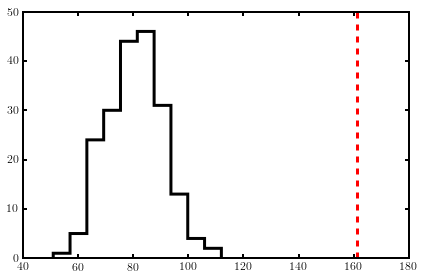

In [22]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(200)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

OK, this looks like the default Raghavan binary population model underpredicts the number of EBs in this period range by about a factor of 2.

Let's try to find a new EB population model that at least reproduces the right number of EBs.  Start with a powerlaw model rather than the log-normal from Raghavan+.

In [10]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets, ecc_empirical=True)
ebpop.params

{'beta': -0.75,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.15,
 'gamma': 0.3,
 'period_max': 7300,
 'period_min': 5,
 'qmin': 0.1}

0
EB: dmag regressor trained, R2=0.999530371454
EB: qR regressor trained, R2=0.999547613838
99


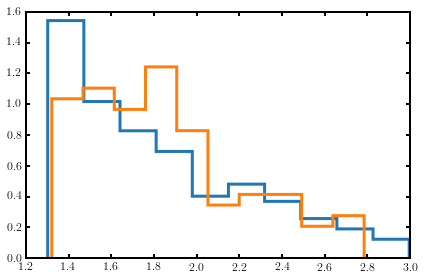

In [11]:
min_period = 20
ebpop.set_params(beta=-0.95, period_min=min_period, fB=0.14)

q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True);
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period),
        histtype='step', lw=3, normed=True);
print(len(new_obs))

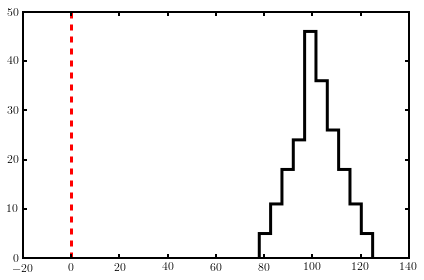

In [12]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(200)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

In [16]:
c = ebpop.observe()

In [26]:
c.head()

,host,period,ecc,w,inc,a,aR,b_pri,b_sec,k,...,T23_pri,T23_sec,dataspan,dutycycle,b_target,flux_ratio,dilution,n_pri,n_sec,phase_sec
0,1190,740.215783,0.625931,2.099396,1.565043,2.598295e+13,364.566571,0.828162,2.776465,0.330269,...,0.000000,0.000000,1459.789,0.8755,13.851932,0.006075,1,2,0,0.266869
1,3672,93.548023,0.663654,0.381173,1.545903,7.359202e+12,109.615596,1.224410,2.027180,0.792208,...,0.000000,0.000000,1459.789,0.8753,14.891845,0.353098,1,11,0,0.875490
2,3809,73.410919,0.250570,4.215533,1.557530,5.978814e+12,113.271095,1.806121,1.154073,0.999722,...,0.000000,0.000000,1459.789,0.8751,16.582071,0.999494,1,17,18,0.422244
3,7156,280.794317,0.498939,1.885877,1.560288,1.445402e+13,231.184227,1.237467,3.471102,0.641239,...,0.000000,0.000000,1459.789,0.8753,16.356929,0.066798,1,5,0,0.388763
4,9295,44.142544,0.336003,4.611192,1.567758,4.342152e+12,50.555094,0.204678,0.102120,0.545398,...,0.159619,0.086911,1459.789,0.8755,14.134066,0.095134,1,26,25,0.477076


In [27]:
s = ebpop.get_target(1190)

In [29]:
s[['kepid', 'kepid']]

kepid    10075199
kepid    10075199
Name: 1190, dtype: object

In [23]:
%timeit [ebpop.get_noise(c.host[0], 3.5) for i in range(1000)]

1 loops, best of 3: 360 ms per loop


OK, now that we can roughly match the Kepler EB catalog from 10 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [26]:
dfm_q = 'n_pri < 3 and n_sec < 3 and (n_pri==0 or n_sec==0)'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True).query(dfm_q)) for i in range(200)]
nobs_bg = [len(bgpop.observe(new_orbits=True).query(dfm_q)) for i in range(200)]

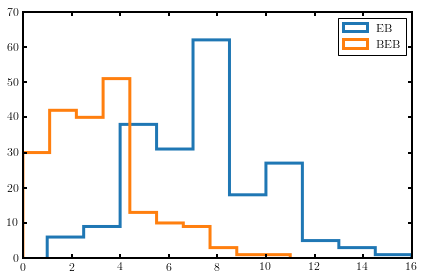

In [27]:
plt.hist(nobs_eb, histtype='step', lw=3, label='EB');
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB');
plt.legend();

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.  First, train the trapezoid regressions.

In [18]:
ebpop._train_trap(N=1000);

EB: Depth trained: R2=0.999263944429
EB: Duration trained: R2=0.996395358585
EB: Slope trained: R2=0.974784712751


(Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, cri

In [19]:
bgpop._train_trap(N=1000, use_ic=True);

BGEB: Depth trained: R2=0.998516118526
BGEB: Duration trained: R2=0.993863316155
BGEB: Slope trained: R2=0.988613897698


(Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, cri

In [30]:
N = 2000
eb_obs = ebpop.get_N_observed(query=dfm_q, N=N, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=N, use_ic=True, new_orbits=True)

In [33]:
eb_obs.observed.columns

Index([u'period', u'n_pri', u'logd_pri', u'dur_pri', u'slope_pri', u'n_sec',
       u'logd_sec', u'dur_sec', u'slope_sec', u'phase_sec'],
      dtype='object')

OK, now let's load up the candidates.

In [35]:
candidates = pd.read_csv('../results/candidates.csv').query('accept_bic and accept_time and num_peaks <= 2')
candidates[['depth','transit_duration']].head()

,depth,transit_duration
17,0.003340,0.393807
27,0.078353,1.157742
39,0.015872,0.684503
40,0.015061,0.684186
43,0.023301,0.361075


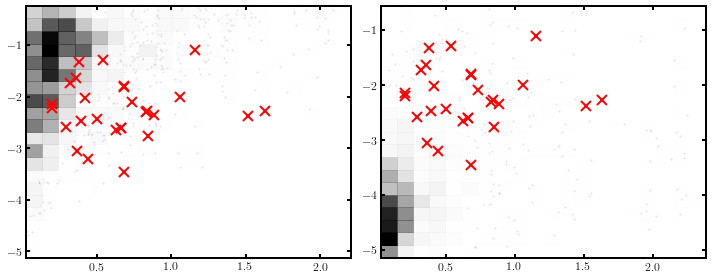

In [53]:
from corner import hist2d

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

hist2d(eb_obs.observed.dur_pri.values, eb_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax1);
hist2d(bg_obs.observed.dur_pri.values, bg_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax2);

for ax in (ax1, ax2):
    ax.plot(candidates.transit_duration, np.log10(candidates.depth), 'rx', ms=10)


In [54]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))

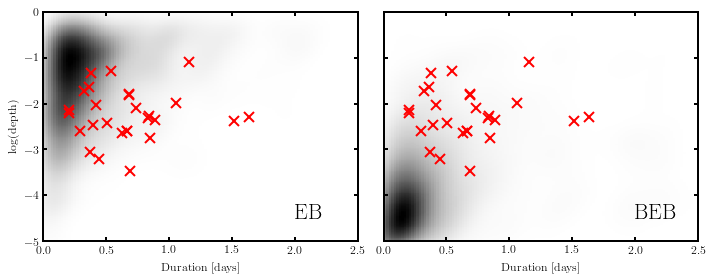

In [56]:
def plot_kde(kde, ax=None, dur_range=(0,2.5), depth_range=(-5,0), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)

In [65]:
len(candidates)

27

In [5]:
from exosyspop.populations import PoissonPlanetPopulation

Rp_min = 0.1 * 11.2 # 0.1 RJ
Rp_max = 11.2 # RJ

plpop = PoissonPlanetPopulation(targets, period_min=2*365.25, period_max=15*365.25,
                                   Rp_min=Rp_min, Rp_max = Rp_max)

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
plpop._train_trap(N=1000)

Planet: Depth trained: R2=0.999636092102
Planet: Duration trained: R2=0.991688614518
Planet: Slope trained: R2=0.977178161133


(Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
 Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', RandomForestRegressor(bootstrap=True, cri

In [7]:
o = plpop.observe(regr_trap=True)

In [9]:
o[['k','d_pri', 'snr_pri', 'noise_pri']]

,k,d_pri,snr_pri,noise_pri
0,0.015327,0.000267,2.407311,127.899459
1,0.065126,0.000000,NaN,117.358000
2,0.033897,0.001352,5.462966,197.927000
3,0.024596,0.000618,8.094914,61.171000
4,0.022123,0.000583,3.826995,175.845000
5,0.010825,0.000093,0.461298,229.823000
6,0.018848,0.000433,1.292634,273.859153
7,0.027947,0.000676,3.922094,134.161000
8,0.099680,0.011700,52.855339,171.603000
9,0.021874,0.000352,3.028783,124.829000


In [8]:
o.columns

Index([u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR', u'b_pri',
       u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan', u'dutycycle',
       u'b_target', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec', u'trap_dur_pri_regr', u'trap_depth_pri_regr',
       u'trap_slope_pri_regr', u'trap_dur_sec_regr', u'trap_depth_sec_regr',
       u'trap_slope_sec_regr', u'noise_pri', u'noise_sec', u'SNR_pri',
       u'SNR_sec'],
      dtype='object')

In [9]:
len(o)

68

In [62]:

nobs_pl = [len(plpop.observe(new_orbits=True).query(dfm_q)) for i in range(200)]

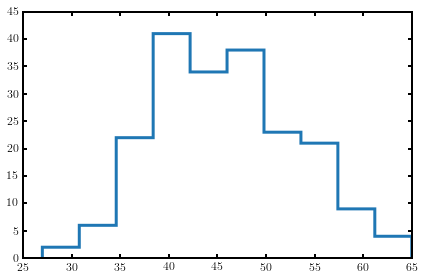

In [64]:
plt.hist(nobs_pl, histtype='step', lw=3, label='planets');